# Forcasting Epidemics With Wikipedia
Every year, epidemics across the globe cost countries billions of dollars, and thousands of lives. With the advent of the internet, and consequently big data, we now have the ability to start reliably quantifying and predicting these disease trends. If successful, countries can work to better mitigate the costly economic and deadly impacts of these epidemics. 

Two classes of media behvaior can be used to monitor disease trends:
1. *Sharing* - Peoples social media sharing of health-related things (e.g. face-mask use)
2. *Health-Seeking* - Web based queries for health-related topics

When people are struck with a disease, often times they search Google for related symptoms, which a lot of the time leads them to a relevant wikipedia article. Therefore, one can analyze the access logs of pertinent articles (of a certain disease) to determine where epidemic outbreaks may be occuring. The pageview logs of Wikipedia do not include IP addresses, but we can infer geographic locaiton of a page access via the article's language.

There are a few additional reasons why Wikipedia may serve to forecast disease incidence:
* Due to seasonality of diseases, people look on Wikipedia for more information
* People reacting to the news (see Google Flu Trends 2009)
* People observing others who are sick, whom might potentially infect them

Google Flu Trends had a solid success rate in predicting influenza incidence. However, in 2009, due to widespread media coverage of the flue that year, there was a large spike in web searches for flu-related topics (i.e. health-seeking behavior). Consequently, Google's models massively overpredicted influenza incidence, and have since shut the project down. In order to combat this, any model basing its predictions off of Wikipedia page view logs must re-calibrate, to avoid any over-predicitons. 


In [1]:
import os
import glob
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
from dateutil.relativedelta import relativedelta
from datetime import datetime
from mwviews.api import PageviewsClient
from collections import defaultdict

In [2]:
def getViews(language, article, start=None, end=None):
    """
    Returns list of tuples of the form (date, pageViews)
    start, end: YYYYMMDDHH
    """
    pvc = PageviewsClient()
    project = language + ".wikipedia"
    data = pvc.article_views(project, [article], start=start, end=end)
    # put the views into a list of tuples, (date, views)
    tuples = [(d, data[d][article]) for d in data]
    # sort the tuples by date
    tuples.sort(key=lambda t: t[0])
    return tuples

def plotViews(language, article, start=None, end=None):    
    # pull the data from the mwviews API, and plot
    startdt, enddt = datetime.strptime(start, '%Y%m%d%H'), datetime.strptime(end, '%Y%m%d%H') 
    numMonths = (enddt.year - startdt.year)*12 + enddt.month - startdt.month
    data = getViews(language, article, start=start, end=end)
    
    months = MonthLocator(range(1,numMonths + 1), bymonthday=1, interval=1)
    monthsFmt = DateFormatter("%b `%y")

    dates = [t[0] for t in data]
    views = [t[1] for t in data]

    fig, ax = plt.subplots()
    ax.plot_date(dates, views, '-')
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(monthsFmt)
    ax.autoscale_view()
    fig.autofmt_xdate()
    plt.show()

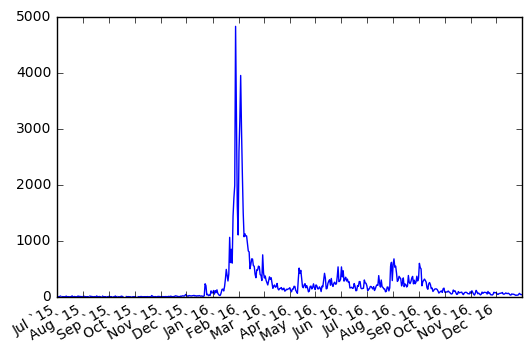

In [3]:
plotViews('en', 'Zika', start='2015010100', end='2016123123')

### Aggregating United States Reported Zika Cases
The CDC provides weekly reports, which are available in CSV form. The data is broken up into Zika incidence in every state, so I will simply aggregate the data from all states.

In [4]:
pd.read_csv("./data/zika/CDC_Report-2016-02-24.csv")[:3]

,report_date,location,location_type,data_field,data_field_code,time_period,time_period_type,value,unit
0,2016-02-24,United_States-Alabama,state,zika_reported_travel,US0001,NaN,NaN,1,cases
1,2016-02-24,United_States-Alabama,state,zika_reported_local,US0002,NaN,NaN,0,cases
2,2016-02-24,United_States-American_Samoa,territory,zika_reported_local,US0002,NaN,NaN,4,cases


In [5]:
path = '/home/william/wikidemics/data/zika'
files = glob.glob(path + "/*.csv")
zika = pd.DataFrame()
for f in sorted(files):
    week = pd.read_csv(f)
    zika = zika.append(week)
weekly = zika.groupby('report_date')['value'].sum()

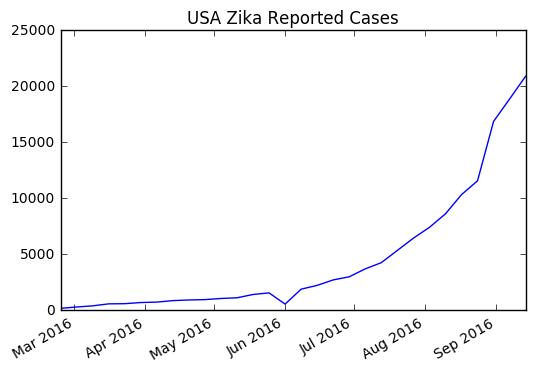

In [6]:
# aggregated weekly sums of incidence
weekly.index = weekly.index.to_datetime()
weekly.plot(title="USA Zika Reported Cases")

### There is not enough reliable Zika incidence data to create a realistic forecasting model - without too much overfitting - therefore I will switch to influenza for now. 